<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_GridWorld(%EB%8B%A4%EB%A5%B8%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

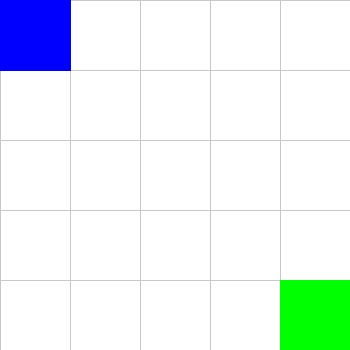

KeyboardInterrupt: 

In [2]:
import numpy as np
import tensorflow as tf
import random
import cv2
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# GridWorld 환경
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size - 1, self.size - 1]
        return self.get_state()

    def get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.size - 1:
            self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.size - 1:
            self.agent_pos[1] += 1

        done = self.agent_pos == self.goal_pos
        reward = 1.0 if done else -0.01
        return self.get_state(), reward, done

    def render(self, delay=200):
        clear_output(wait=True)
        cell_size = 70
        img = np.ones((self.size * cell_size, self.size * cell_size, 3), dtype=np.uint8) * 255

        for i in range(self.size):
            for j in range(self.size):
                x, y = j * cell_size, i * cell_size
                cv2.rectangle(img, (x, y), (x + cell_size, y + cell_size), (200, 200, 200), 1)

        ax, ay = self.agent_pos[1] * cell_size, self.agent_pos[0] * cell_size
        cv2.rectangle(img, (ax, ay), (ax + cell_size, ay + cell_size), (255, 0, 0), -1)

        gx, gy = self.goal_pos[1] * cell_size, self.goal_pos[0] * cell_size
        cv2.rectangle(img, (gx, gy), (gx + cell_size, gy + cell_size), (0, 255, 0), -1)

        cv2_imshow(img)
        time.sleep(delay / 1000.0)

# Q-network
class QNet(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(QNet, self).__init__()
        self.d1 = tf.keras.layers.Dense(32, activation='relu', input_shape=(state_size,))
        self.d2 = tf.keras.layers.Dense(32, activation='relu')
        self.out = tf.keras.layers.Dense(action_size, activation='linear')

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)

# 하이퍼파라미터
grid_size = 5
state_size = grid_size * grid_size
action_size = 4
episodes = 300
sync_interval = 10  # 매 10 에피소드마다 타겟 네트워크 동기화

gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
learning_rate = 0.01

# 환경 및 모델 초기화
env = GridWorld(grid_size)
model = QNet(state_size, action_size)          # 예측 네트워크
target_model = QNet(state_size, action_size)   # 타겟 네트워크
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
target_model.set_weights(model.get_weights())  # 초기 동기화

# 학습 루프
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_input = tf.one_hot(state, state_size)
        state_input = tf.reshape(state_input, [1, state_size])

        if np.random.rand() < epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state_input, verbose=0)
            action = np.argmax(q_values[0])

        next_state, reward, done = env.step(action)
        next_state_input = tf.one_hot(next_state, state_size)
        next_state_input = tf.reshape(next_state_input, [1, state_size])

        target_q = model.predict(state_input, verbose=0)
        if done:
            target_q[0][action] = reward
        else:
            next_q = target_model.predict(next_state_input, verbose=0)  # 🎯 타겟 네트워크 사용
            target_q[0][action] = reward + gamma * np.max(next_q[0])

        model.fit(state_input, target_q, epochs=1, verbose=0)

        state = next_state
        total_reward += reward
        env.render()

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # ✅ 목표 도달 시 출력 및 대기
    if reward == 1.0:
        print(f"✅ Episode {episode+1}: Goal reached! Total reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")
        time.sleep(3)

    # 🎯 타겟 네트워크 업데이트
    if (episode + 1) % sync_interval == 0:
        target_model.set_weights(model.get_weights())
        print(f"🔁 Target network synced at episode {episode+1}")
